In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
from numpy import atleast_2d
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cmap = cm.get_cmap('viridis')
pd.options.display.float_format = '{:,.2f}'.format

### Load Iris Data

In [3]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

### Create DataFrame

In [4]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length (cm)    150 non-null float64
sepal width (cm)     150 non-null float64
petal length (cm)    150 non-null float64
petal width (cm)     150 non-null float64
label                150 non-null int64
dtypes: float64(4), int64(1)
memory usage: 5.9 KB


### Standardize Data

In [5]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [6]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

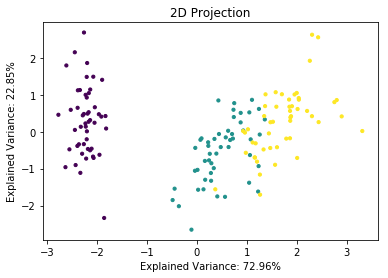

In [7]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure().gca(title='2D Projection', 
                      xlabel='Explained Variance: {:.2%}'.format(ev1), 
                      ylabel='Explained Variance: {:.2%}'.format(ev2))
ax.scatter(*features_2D.T, c=data.label, s=10);

### Perform GMM clustering

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Text(0.5, 1.0, 'Clusters | MI=0.90')

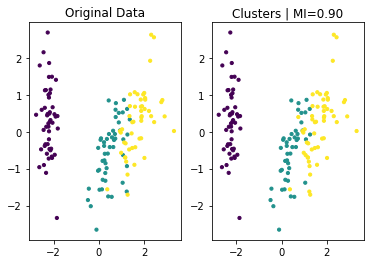

In [8]:
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(features_standardized)
data['clusters'] = gmm.predict(features_standardized)
fig, axes = plt.subplots(ncols=2)
labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
axes[0].scatter(*features_2D.T, c=data.label, s=10)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=10)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

### Visualized Gaussian Distributions

In [9]:
xmin, ymin = features_2D.min(axis=0)
xmax, ymax = features_2D.max(axis=0)

x = np.linspace(xmin, xmax, 500)
y = np.linspace(ymin, ymax, 500)
X, Y = np.meshgrid(x, y)

simulated_2D = np.column_stack([np.ravel(X), np.ravel(Y)])
simulated_4D = pca.inverse_transform(simulated_2D)
Z = atleast_2d(np.clip(np.exp(gmm.score_samples(simulated_4D)), a_min=0, a_max=1)).reshape(X.shape)

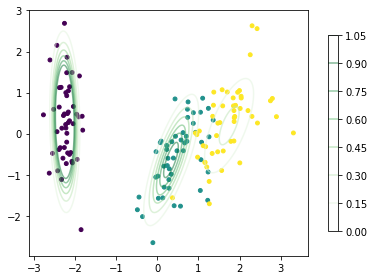

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
CS = ax.contour(X, Y, Z, cmap='Greens', alpha=.5)
CB = plt.colorbar(CS, shrink=0.8)
ax.scatter(*features_2D.T, c=data.label, s=15)
fig.tight_layout();

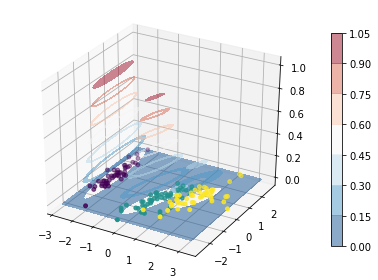

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect('equal')
CS = ax.contourf3D(X, Y, Z, cmap='RdBu_r', alpha=.5)
CB = plt.colorbar(CS, shrink=0.8)
ax.scatter(*features_2D.T, c=data.label, s=15)
fig.tight_layout()
fig.savefig('gaussian3d', dpi=300)

### Bayesian Information Criterion 

In [13]:
bic = {}
for n_components in range(2, 8):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(features_standardized)
    bic[n_components] = gmm.bic(features_standardized)
pd.Series(bic)

2   794.71
3   801.55
4   796.24
5   862.55
6   897.52
7   991.30
dtype: float64

In [ ]:
dd